In [1]:
import sys, os
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable, List
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

import collections
import pandas as pd 
import numpy as np
import random 
from torch.utils.data import DataLoader, random_split
import scanpy as sc

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy
from utils import plot_train

In [2]:
# Data
path_mtx = r"./data/mtx_0.mtx"
data_test = sc.read_mtx(path_mtx)

In [3]:
# PREVIEW
load_data = data_test.copy()
sc.pp.filter_genes(load_data, min_cells=50)
print(data_test.shape, load_data.shape)

(238, 27943) (238, 5050)


In [4]:
batch_size = 32
all_data = np.array(load_data.X.todense())

seed = 222
random.seed(seed)

m = len(all_data)
print(m)

train_data, test_data = random_split(dataset=all_data, lengths=[int(m - m * 0.2), int(m * 0.2) + 1])

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

238


In [5]:
net_struc = [all_data.shape[1], 1024, 512, 256, 128, 64]

encoder = Encoder(features=net_struc)
decoder = Decoder(features=net_struc[1:][::-1])
output_layer = OutputLayer(net_struc[0], net_struc[1])
# loss_fn = MMD_LOSS()
loss_fn = nn.MSELoss()

# Define Optimizer
lr = 0.0005

#Random seed
torch.manual_seed(seed)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr, weight_decay=1e-05)

In [6]:
# Training
def train_epoch(encoder, decoder, dataloader, optimizer):
    encoder.train()
    decoder.train()
    output_layer.train()
    train_loss = 0.0
    for sc_data_batch in dataloader:
        # Encode
        encoded_data = encoder(sc_data_batch)
        # Decode
        decoded_data = decoder(encoded_data)

        # Compute params for DCA
        mean_param, pi_param, theta_param = output_layer(decoded_data)

        # Evaluate loss
        zinb = ZINB(pi_param, theta=theta_param)
        zinb_loss = (zinb.loss(mean_param, sc_data_batch))
        mmd_loss = maximum_mean_discrepancy(mean_param, sc_data_batch)
        loss = zinb_loss * 0.5 + mmd_loss * 0.5
        
        # Backword 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

In [7]:
# Testing func
def test_epoch(encoder, decoder, dataloader):
    encoder.eval()
    decoder.eval()
    output_layer.eval()
    test_loss = 0.0
    with torch.no_grad(): # Don't track gradients
        for sc_data_batch in dataloader:
            # Encode
            encoded_data = encoder(sc_data_batch)
            # Decode
            decoded_data = decoder(encoded_data)
            # Compute params for DCA
            mean_param, pi_param, theta_param = output_layer(decoded_data)

            zinb = ZINB(pi_param, theta=theta_param)

            zinb_loss = (zinb.loss(mean_param, sc_data_batch))
            mmd_loss = maximum_mean_discrepancy(mean_param, sc_data_batch)
            loss = zinb_loss * 0.5 + mmd_loss * 0.5
            
            test_loss += loss.item()
    return test_loss / len(dataloader.dataset)

d:\Francis Secrets\Pycharm Projects\antennaVAE\AntennaVAE\loss_function.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pi = torch.tensor(pi)
d:\Francis Secrets\Pycharm Projects\antennaVAE\AntennaVAE\loss_function.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nb_case = super().loss(y_true, y_pred, mean=False) - torch.log(torch.tensor(1.0-self.pi+eps))



 EPOCH 1/50 	 train loss inf 	 val loss 0.3743499716122945

 EPOCH 2/50 	 train loss inf 	 val loss 0.3628242015838623

 EPOCH 3/50 	 train loss inf 	 val loss 0.35598524411519367

 EPOCH 4/50 	 train loss inf 	 val loss 0.3524336020151774

 EPOCH 5/50 	 train loss inf 	 val loss 0.3471100131670634


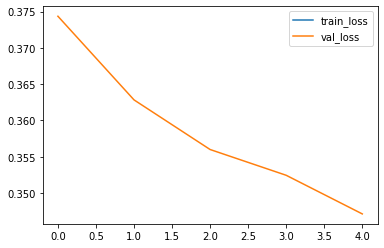


 EPOCH 6/50 	 train loss inf 	 val loss 0.34352125724156696

 EPOCH 7/50 	 train loss inf 	 val loss 0.3404008944829305

 EPOCH 8/50 	 train loss inf 	 val loss 0.33883296449979144

 EPOCH 9/50 	 train loss inf 	 val loss 0.33701030413309735

 EPOCH 10/50 	 train loss inf 	 val loss 0.33525153001149494


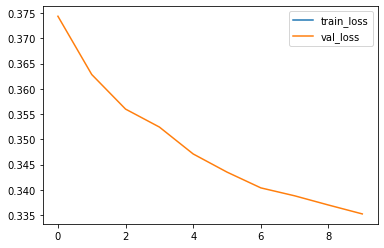


 EPOCH 11/50 	 train loss inf 	 val loss 0.3326440652211507

 EPOCH 12/50 	 train loss inf 	 val loss 0.3293267885843913

 EPOCH 13/50 	 train loss inf 	 val loss 0.3248358766237895

 EPOCH 14/50 	 train loss inf 	 val loss 0.32038283348083496

 EPOCH 15/50 	 train loss inf 	 val loss 0.3152446349461873


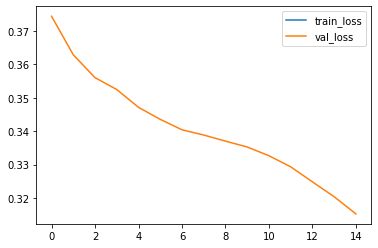


 EPOCH 16/50 	 train loss inf 	 val loss 0.3082563877105713

 EPOCH 17/50 	 train loss inf 	 val loss 0.29820088545481366

 EPOCH 18/50 	 train loss inf 	 val loss 0.2914826273918152

 EPOCH 19/50 	 train loss inf 	 val loss 0.2863154609998067

 EPOCH 20/50 	 train loss inf 	 val loss 0.27871395150820416


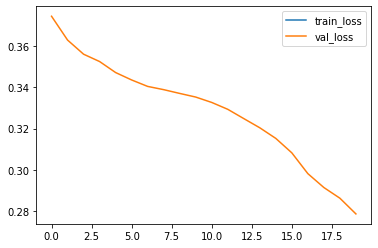


 EPOCH 21/50 	 train loss inf 	 val loss 0.27330853541692096

 EPOCH 22/50 	 train loss inf 	 val loss 0.27062798539797467

 EPOCH 23/50 	 train loss inf 	 val loss 0.2677837709585826

 EPOCH 24/50 	 train loss inf 	 val loss 0.2586846947669983

 EPOCH 25/50 	 train loss inf 	 val loss 0.2491206427415212


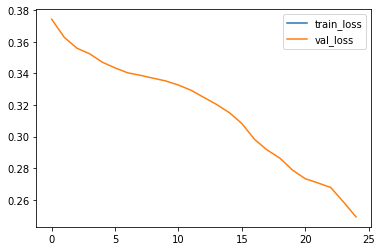


 EPOCH 26/50 	 train loss inf 	 val loss 0.23759877681732178

 EPOCH 27/50 	 train loss inf 	 val loss 0.22898436586062113

 EPOCH 28/50 	 train loss inf 	 val loss 0.22308078408241272

 EPOCH 29/50 	 train loss inf 	 val loss 0.2184318800767263

 EPOCH 30/50 	 train loss inf 	 val loss inf


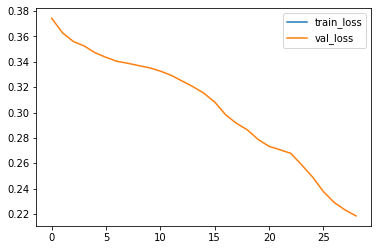


 EPOCH 31/50 	 train loss inf 	 val loss inf

 EPOCH 32/50 	 train loss inf 	 val loss inf

 EPOCH 33/50 	 train loss inf 	 val loss inf

 EPOCH 34/50 	 train loss inf 	 val loss inf

 EPOCH 35/50 	 train loss inf 	 val loss inf


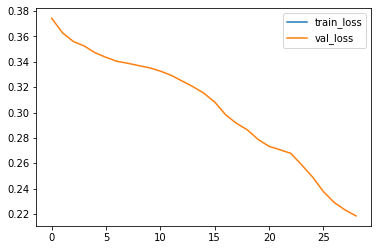


 EPOCH 36/50 	 train loss inf 	 val loss inf

 EPOCH 37/50 	 train loss inf 	 val loss inf

 EPOCH 38/50 	 train loss inf 	 val loss inf

 EPOCH 39/50 	 train loss inf 	 val loss inf

 EPOCH 40/50 	 train loss inf 	 val loss inf


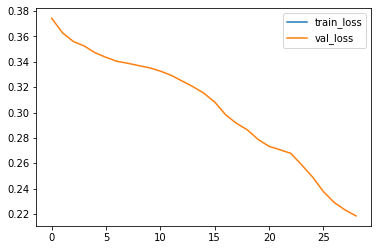


 EPOCH 41/50 	 train loss inf 	 val loss inf

 EPOCH 42/50 	 train loss inf 	 val loss inf

 EPOCH 43/50 	 train loss inf 	 val loss inf

 EPOCH 44/50 	 train loss inf 	 val loss inf

 EPOCH 45/50 	 train loss inf 	 val loss inf


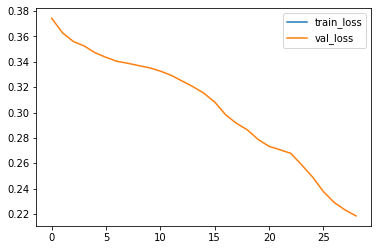


 EPOCH 46/50 	 train loss inf 	 val loss inf

 EPOCH 47/50 	 train loss inf 	 val loss inf

 EPOCH 48/50 	 train loss inf 	 val loss inf

 EPOCH 49/50 	 train loss inf 	 val loss inf

 EPOCH 50/50 	 train loss inf 	 val loss inf


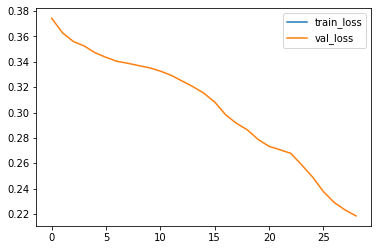

In [8]:
num_epochs = 50
all_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder, train_loader,optim)
   test_loss = test_epoch(encoder,decoder,test_loader)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,test_loss))
   all_loss['train_loss'].append(train_loss)
   all_loss['val_loss'].append(test_loss)
   if epoch and (epoch + 1) % 5 == 0:
      plot_train(all_loss)

In [ ]:
torch.tensor(1)+ torch.nan

tensor(nan)